# Reddit Wall Street Bets Sentiment Analysis

<img src="../images/reddit.jpg">

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import spacy
import re
import plotly.express as px

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from matplotlib.pyplot import figure
from datetime import datetime

### Data Cleaning / Text Preprocessing

In [95]:
df = pd.read_csv('../reddit_wsb.csv')

In [96]:
df_gme = pd.read_csv('../gme.csv')

In [97]:
df.head(5)

,title,score,id,url,comms_num,created,body,timestamp,change (+/-),Dates,Unnamed: 10
0,An autists journey. $150 to $68k in one month....,50,l6h58v,https://www.reddit.com/gallery/l6h58v,8,1611817696,NaN,1/28/2021 9:08,1.0,1/28/2021,NaN
1,You all have made Melvin live up to its name,70,l6h59b,https://i.redd.it/59sk10r7iyd61.png,7,1611817697,NaN,1/28/2021 9:08,1.0,1/29/2021,NaN
2,I got in late on GME but I believe in the caus...,75,l6h5a2,https://www.reddit.com/r/wallstreetbets/commen...,14,1611817698,You guys are amazing. Thank you for sending GM...,1/28/2021 9:08,1.0,2/1/2021,NaN
3,Highest SI % of Float End of Business Jan 27th...,26,l6h5am,https://www.reddit.com/r/wallstreetbets/commen...,22,1611817699,Will Update Daily At Market Close\n\nTop 5 sec...,1/28/2021 9:08,1.0,2/2/2021,NaN
4,Discord still down,0,l6h5bt,https://www.reddit.com/r/wallstreetbets/commen...,6,1611817701,i can't see how to talk to to any anti bot mea...,1/28/2021 9:08,1.0,2/3/2021,NaN


In [98]:
df_gme.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume,Change,Change (+/-)
0,1/28/2021,265.000000,483.000000,112.250000,193.600006,193.600006,58815800.0,0.000000,1.0
1,1/29/2021,379.709991,413.980011,250.000000,325.000000,325.000000,50566100.0,131.399994,1.0
2,2/1/2021,316.559998,322.000000,212.000000,225.000000,225.000000,37382200.0,-100.000000,0.0
3,2/2/2021,140.759995,158.000000,74.220001,90.000000,90.000000,78183100.0,-135.000000,0.0
4,2/3/2021,112.010002,113.400002,85.250000,92.410004,92.410004,42698500.0,2.410004,1.0


In [99]:
# Drop unnecessary columns for analysis
df = df.drop(columns=['id', 'url', 'created', 'Unnamed: 10', 'Dates'])

In [100]:
df_gme = df_gme.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume', 'Change'])

In [101]:
# Handle missing values
df.isnull().sum()

title            9017
score            9023
comms_num        9028
body            28597
timestamp        9035
change (+/-)     9035
dtype: int64

In [102]:
df_gme.isnull().sum()

Date            1
Adj Close       1
Change (+/-)    1
dtype: int64

In [103]:
# Information about dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46184 entries, 0 to 46183
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         37167 non-null  object 
 1   score         37161 non-null  object 
 2   comms_num     37156 non-null  object 
 3   body          17587 non-null  object 
 4   timestamp     37149 non-null  object 
 5   change (+/-)  37149 non-null  float64
dtypes: float64(1), object(5)
memory usage: 2.1+ MB


In [104]:
df_gme.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          63 non-null     object 
 1   Adj Close     63 non-null     float64
 2   Change (+/-)  63 non-null     float64
dtypes: float64(2), object(1)
memory usage: 1.6+ KB


In [105]:
# Describe dataset
df.describe()

,change (+/-)
count,37149.000000
mean,0.744946
std,0.435897
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [106]:
df_gme.describe()

,Adj Close,Change (+/-)
count,63.000000,63.000000
mean,148.368889,0.444444
std,66.189996,0.500895
min,40.590000,0.000000
25%,97.075001,0.000000
50%,158.509995,0.000000
75%,190.635002,1.000000
max,325.000000,1.000000


In [107]:
df.head(10)

,title,score,comms_num,body,timestamp,change (+/-)
0,An autists journey. $150 to $68k in one month....,50,8,NaN,1/28/2021 9:08,1.0
1,You all have made Melvin live up to its name,70,7,NaN,1/28/2021 9:08,1.0
2,I got in late on GME but I believe in the caus...,75,14,You guys are amazing. Thank you for sending GM...,1/28/2021 9:08,1.0
3,Highest SI % of Float End of Business Jan 27th...,26,22,Will Update Daily At Market Close\n\nTop 5 sec...,1/28/2021 9:08,1.0
4,Discord still down,0,6,i can't see how to talk to to any anti bot mea...,1/28/2021 9:08,1.0
5,What are you doing to AMC?,67,55,Hey retards what the hell is going on with AMC...,1/28/2021 9:08,1.0
6,HOW CAN I BUY STOCK????!!!,0,12,I'm from canada and want to know the best trad...,1/28/2021 9:08,1.0
7,"Buy games at GameStop, donate to charity (not ...",50,9,"Value goes up, kids play video games",1/28/2021 9:08,1.0
8,How do i invest in GameStop? I don't know anyt...,0,21,NaN,1/28/2021 9:08,1.0
9,Hmmmmmm turns out BlackRock is making use of o...,66,8,NaN,1/28/2021 9:08,1.0


In [108]:
df_gme.head(10)

,Date,Adj Close,Change (+/-)
0,1/28/2021,193.600006,1.0
1,1/29/2021,325.000000,1.0
2,2/1/2021,225.000000,0.0
3,2/2/2021,90.000000,0.0
4,2/3/2021,92.410004,1.0
5,2/4/2021,53.500000,0.0
6,2/5/2021,63.770000,1.0
7,2/8/2021,60.000000,0.0
8,2/9/2021,50.310001,0.0
9,2/10/2021,51.200001,1.0


### Data Cleaning / Data Preprocessing

In [109]:
nltk.download('punkt')
porter = nltk.PorterStemmer()

[nltk_data] Downloading package punkt to C:\Users\Abhi
[nltk_data]     Joshi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [110]:
def text_preprocessing(text): 
    # tokenization, remove punctuation, lemmatization
    words = word_tokenize(str(text))
    words = RegexpTokenizer(r'\w+')
    words = [porter.stem(t) for t in str(text).split()]
    
    # remove symbols, websites, email addresses 
    words = [re.sub(r"[^A-Za-z@]", "", word) for word in words] 
    words = [re.sub(r"\S+com", "", word) for word in words]
    words = [re.sub(r"\S+@\S+", "", word) for word in words] 
    words = [word for word in words if word != " " and word != ""]
    words = [word for word in words if len(word) != 0] 
    
    # remove stopwords     
    stopwords = set(STOPWORDS)
    stopwords.update(nltk.corpus.stopwords.words('english'))
    stopwords_lower = [s.lower() for s in stopwords]
    words=[word.lower() for word in words if word.lower() not in stopwords_lower]
    
    # combine a list into one string   
    string = " ".join(words)
    
    return string

In [111]:
df['title_cleaned'] = df['title'].apply(text_preprocessing)
df['body_cleaned'] = df['body'].apply(text_preprocessing)

In [112]:
df.head(10)

,title,score,comms_num,body,timestamp,change (+/-),title_cleaned,body_cleaned
0,An autists journey. $150 to $68k in one month....,50,8,NaN,1/28/2021 9:08,1.0,autist journey one month storytim,nan
1,You all have made Melvin live up to its name,70,7,NaN,1/28/2021 9:08,1.0,made melvin live name,nan
2,I got in late on GME but I believe in the caus...,75,14,You guys are amazing. Thank you for sending GM...,1/28/2021 9:08,1.0,got late gme believ caus lose,guy amazing thank send gme moon know im go los...
3,Highest SI % of Float End of Business Jan 27th...,26,22,Will Update Daily At Market Close\n\nTop 5 sec...,1/28/2021 9:08,1.0,highest si float end busi jan th accord partner,updat daili market close top secur si float en...
4,Discord still down,0,6,i can't see how to talk to to any anti bot mea...,1/28/2021 9:08,1.0,discord still,cant see talk ani anti bot measure ani admin c...
5,What are you doing to AMC?,67,55,Hey retards what the hell is going on with AMC...,1/28/2021 9:08,1.0,amc,hey retard hell go amc hours tri give prematur...
6,HOW CAN I BUY STOCK????!!!,0,12,I'm from canada and want to know the best trad...,1/28/2021 9:08,1.0,buy stock,im canada want know best trade platform use bu...
7,"Buy games at GameStop, donate to charity (not ...",50,9,"Value goes up, kids play video games",1/28/2021 9:08,1.0,buy game gamestop donat chariti goodwill,valu goe kid play video game
8,How do i invest in GameStop? I don't know anyt...,0,21,NaN,1/28/2021 9:08,1.0,invest gamestop dont know anyth stock markets,nan
9,Hmmmmmm turns out BlackRock is making use of o...,66,8,NaN,1/28/2021 9:08,1.0,hmmmmmm turn blackrock make use weapon autism,nan


### Exploratory Data Analysis

In [113]:
# Extract titles and bodies of the wsbets posts
vis_df = df[['title', 'body']].copy()
vis_df.head(10)

,title,body
0,An autists journey. $150 to $68k in one month....,NaN
1,You all have made Melvin live up to its name,NaN
2,I got in late on GME but I believe in the caus...,You guys are amazing. Thank you for sending GM...
3,Highest SI % of Float End of Business Jan 27th...,Will Update Daily At Market Close\n\nTop 5 sec...
4,Discord still down,i can't see how to talk to to any anti bot mea...
5,What are you doing to AMC?,Hey retards what the hell is going on with AMC...
6,HOW CAN I BUY STOCK????!!!,I'm from canada and want to know the best trad...
7,"Buy games at GameStop, donate to charity (not ...","Value goes up, kids play video games"
8,How do i invest in GameStop? I don't know anyt...,NaN
9,Hmmmmmm turns out BlackRock is making use of o...,NaN


In [114]:
# Combine into plain text column
vis_df = vis_df.dropna()
vis_df['combined'] = vis_df['title'] + ' ' + vis_df['body']
vis_df = vis_df.reset_index()

In [115]:
vis_df.head(10)

,index,title,body,combined
0,2,I got in late on GME but I believe in the caus...,You guys are amazing. Thank you for sending GM...,I got in late on GME but I believe in the caus...
1,3,Highest SI % of Float End of Business Jan 27th...,Will Update Daily At Market Close\n\nTop 5 sec...,Highest SI % of Float End of Business Jan 27th...
2,4,Discord still down,i can't see how to talk to to any anti bot mea...,Discord still down i can't see how to talk to ...
3,5,What are you doing to AMC?,Hey retards what the hell is going on with AMC...,What are you doing to AMC? Hey retards what th...
4,6,HOW CAN I BUY STOCK????!!!,I'm from canada and want to know the best trad...,HOW CAN I BUY STOCK????!!! I'm from canada and...
5,7,"Buy games at GameStop, donate to charity (not ...","Value goes up, kids play video games","Buy games at GameStop, donate to charity (not ..."
6,12,Can we become a force for good with our power?,"Hey Gang,\n\nLong time user that recently got ...",Can we become a force for good with our power?...
7,13,Did I just get fucked investing into NAKD,Did I fall for a pump and dump is my money gon...,Did I just get fucked investing into NAKD Did ...
8,17,Is it too late to buy Gamestop shares?,I’ve been really busy this week and haven’t be...,Is it too late to buy Gamestop shares? I’ve be...
9,18,Pending transfer RH question,Will upgrading to RH Gold make my current pend...,Pending transfer RH question Will upgrading to...


In [116]:
# Now let's run the same analysis for all posts
text = ' '.join(vis_df.combined)
print ("There are {} words in the combination of all posts and titles on r/wsbets.".format(len(text)))

There are 18734332 words in the combination of all posts and titles on r/wsbets.


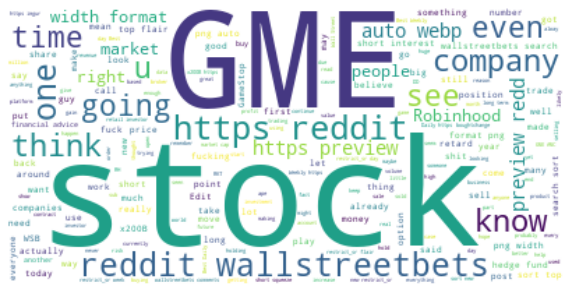

In [117]:
# Create stopword list
stopwords = set(STOPWORDS)
stopwords.update(nltk.corpus.stopwords.words('english'))

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [118]:
# Visualize GME stock prices over time
fig = px.line(df_gme, x='Date', y='Adj Close', title="GME Stock Prices over Time")
fig.show()